In [1]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines

options(repr.plot.width=6, repr.plot.height=4)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: survival


In [2]:
path = '/Users/davide/Documents/universita/tesi/src/pharmacological_counting_process'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data.RData')

In [3]:
head(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,sum_past_qt_prest
10000717,-0.5,101.0,1,M,72,0,0
10000717,101.0,130.0,1,M,72,1,56
10000717,130.0,176.0,1,M,72,2,112
10000717,176.0,197.0,1,M,72,3,168
10000717,197.0,212.0,1,M,72,4,182
10000717,212.0,247.0,1,M,72,5,238
10000717,247.0,344.0,1,M,72,6,350
10000717,344.0,365.5,0,M,72,7,406


# Extended Cox model (recurrent events, time varying features)

In [4]:
model = coxph(Surv(start,stop,status)~ age_in  + Nm + cluster(id), data = sel_df)

## Evaluate goodness of fit

In [88]:
# TODO

## Compute and smooth baseline Hazards

In [5]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [90]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(0,0,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


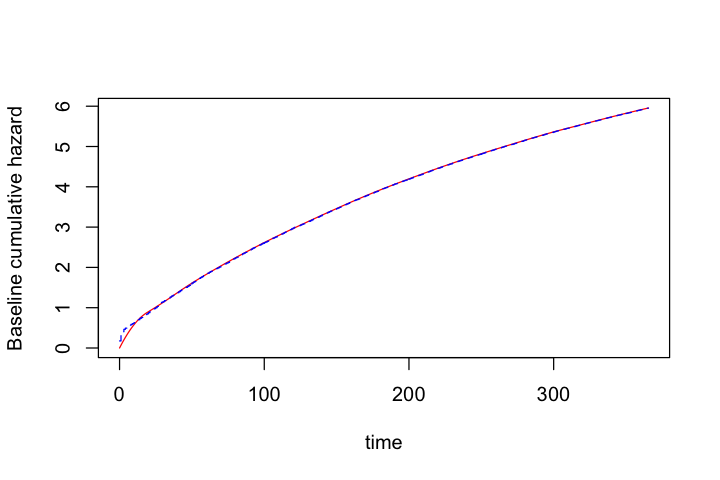

In [91]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

## Reconstruct patients cumulative Hazards

In [552]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

[1] "Computing coefficients ck"
  |======================================================================| 100%[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%

In [7]:
head(cumulative_hazard)

id,time,cumhaz
10000717,0,1.359741e-14
10000717,1,5.958532e-02
10000717,2,1.169584e-01
10000717,3,1.721192e-01
10000717,4,2.250678e-01
10000717,5,2.758041e-01


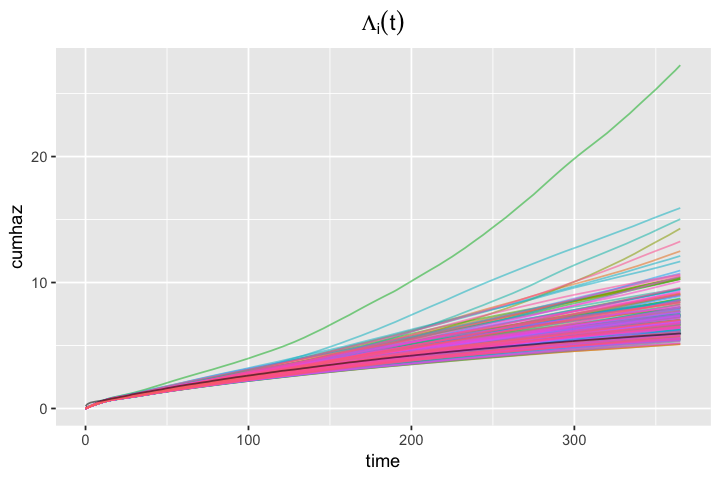

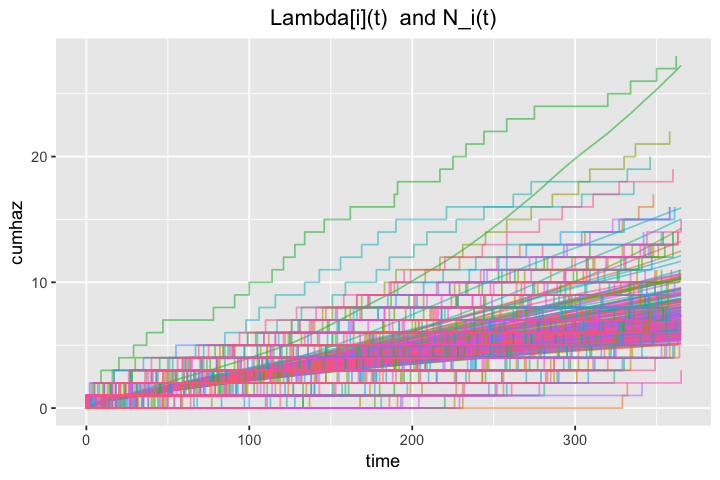

In [41]:
# select a sample to plot
sample_patients = sample(unique(sel_df$id),200)
sample = cumulative_hazard[cumulative_hazard$id %in% sample_patients,]
sample_N = sel_df[id %in% sample_patients,]
bh['id'] = 0

# plot
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_line(data = bh, aes(x= time, y=hazard), color = 'black') +
    ggtitle(expression(Lambda[i](t))) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

# plot also realization
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_step(data = sample_N, aes(x= start, y=Nm,group = factor(id), color=factor(id))) +
    ggtitle(paste(expression(Lambda[i](t)),' and N_i(t)')) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

In [566]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards.RData')

In [6]:
load('../../data/cumulative_hazards.RData')

## Check Martingale residuals

In [24]:
# load dataset of daily realizations (to build it the first time, uncomment the next line)
# source('compute_daily realizations.R')
load('../../data/daily_realizations.RData')

In [33]:
# compute residuals
residuals = cbind(cumulative_hazard, Nt = daily_realizations$Nt)
residuals['residuals'] = residuals$cumhaz - residuals$Nt
residuals = data.table(residuals)

# compute mean residuals
mean_residuals = residuals[,list('residuals' = mean(residuals)), by = 'time']

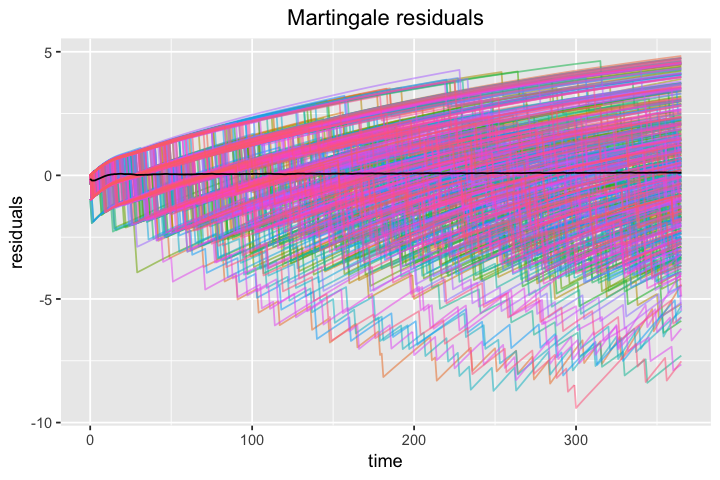

In [34]:
# select sample of patients to plot
sample_patients = sample(unique(sel_df$id),500)
sample = residuals[id %in% sample_patients,]

# plot
ggplot(data = mean_residuals, aes(x= time, y=residuals)) +
    geom_line() +
    geom_line(data = sample, aes(x= time, y=residuals, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line(data = mean_residuals, aes(x= time, y=residuals)) +
    ggtitle('Martingale residuals') +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))